In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder

import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('/kaggle/input/predict-the-genetic-disorders-datasetof-genomes/train_genetic_disorders.csv')

In [4]:
df['Genetic Disorder'].unique()

array(['Mitochondrial genetic inheritance disorders', nan,
       'Multifactorial genetic inheritance disorders',
       'Single-gene inheritance diseases'], dtype=object)

<Axes: >

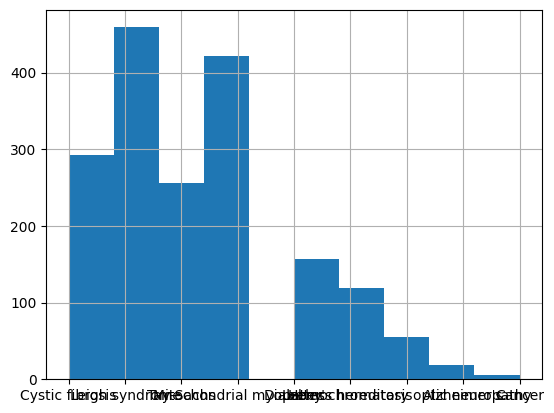

In [5]:
df.loc[df['Genetic Disorder'].isna(), 'Disorder Subclass'].hist()

In [6]:
# дропаем строки без таргета
# df = df[~df['Genetic Disorder'].isna()]
# df = df[~df['Disorder Subclass'].isna()]

In [7]:
df.columns

Index(['Patient Id', 'Patient Age', 'Genes in mother's side',
       'Inherited from father', 'Maternal gene', 'Paternal gene',
       'Blood cell count (mcL)', 'Patient First Name', 'Family Name',
       'Father's name', 'Mother's age', 'Father's age', 'Institute Name',
       'Location of Institute', 'Status', 'Respiratory Rate (breaths/min)',
       'Heart Rate (rates/min', 'Test 1', 'Test 2', 'Test 3', 'Test 4',
       'Test 5', 'Parental consent', 'Follow-up', 'Gender', 'Birth asphyxia',
       'Autopsy shows birth defect (if applicable)', 'Place of birth',
       'Folic acid details (peri-conceptional)',
       'H/O serious maternal illness', 'H/O radiation exposure (x-ray)',
       'H/O substance abuse', 'Assisted conception IVF/ART',
       'History of anomalies in previous pregnancies',
       'No. of previous abortion', 'Birth defects',
       'White Blood cell count (thousand per microliter)', 'Blood test result',
       'Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'S

In [8]:
df.describe()

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,White Blood cell count (thousand per microliter),Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5
count,19643.000000,21011.000000,15293.000000,15322.000000,18992.0,18958.0,18970.0,18962.0,18939.0,18957.000000,18965.000000,18955.000000,18899.000000,19008.000000,18987.000000,18956.000000
mean,6.974851,4.899004,34.522527,41.942436,0.0,0.0,0.0,1.0,0.0,2.000106,7.484680,0.592034,0.552886,0.537405,0.497393,0.460804
std,4.322584,0.199829,9.847256,13.027701,0.0,0.0,0.0,0.0,0.0,1.411488,2.653633,0.491470,0.497208,0.498612,0.500006,0.498474
min,0.000000,4.092727,18.000000,20.000000,0.0,0.0,0.0,1.0,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.763230,26.000000,31.000000,0.0,0.0,0.0,1.0,0.0,1.000000,5.419026,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,4.899548,35.000000,42.000000,0.0,0.0,0.0,1.0,0.0,2.000000,7.473071,1.000000,1.000000,1.000000,0.000000,0.000000
75%,11.000000,5.033977,43.000000,53.000000,0.0,0.0,0.0,1.0,0.0,3.000000,9.528684,1.000000,1.000000,1.000000,1.000000,1.000000
max,14.000000,5.609829,51.000000,64.000000,0.0,0.0,0.0,1.0,0.0,4.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Видим, что тесты у всех одинаковые $\rightarrow$ никакой информации они не дают

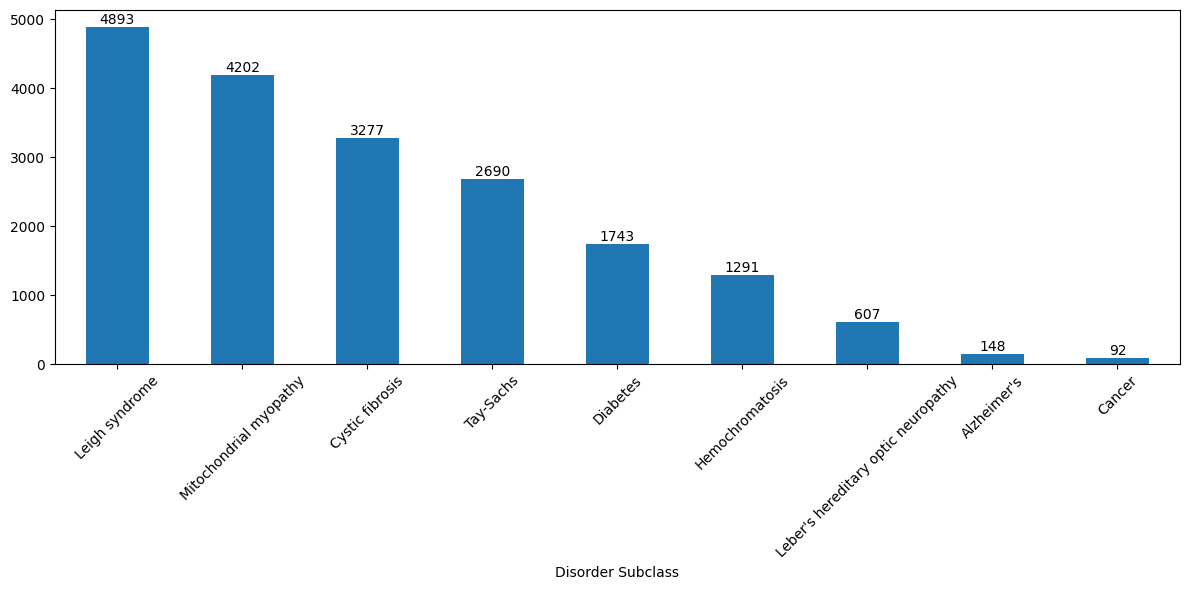

In [9]:
plt.figure(figsize=(12, 6))
target_1 = df['Disorder Subclass']
target_1.value_counts().plot(kind='bar')

plt.xticks(rotation=45) 

for i, count in enumerate(target_1.value_counts()):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout() 
plt.show()

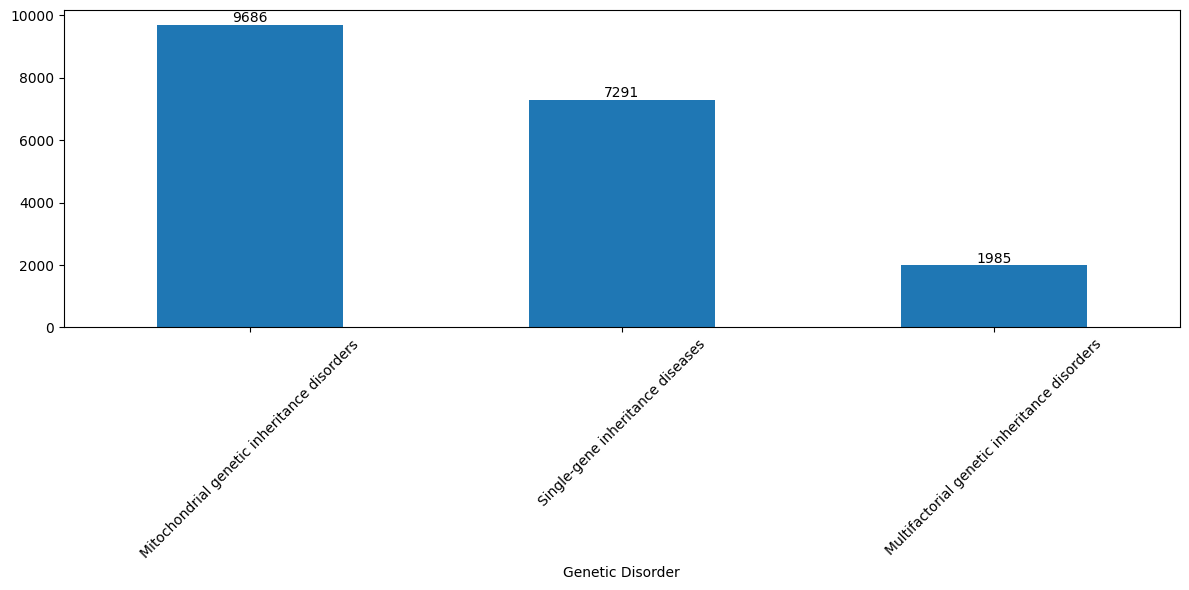

In [10]:
plt.figure(figsize=(12, 6))
target_2 = df['Genetic Disorder']
target_2.value_counts().plot(kind='bar')

plt.xticks(rotation=45) 

for i, count in enumerate(target_2.value_counts()):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout() 
plt.show()

In [11]:
# numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
# categorical_cols = df.select_dtypes(include=['object', 'category']).columns


# num_plots = len(numeric_cols) + len(categorical_cols)
# rows = (num_plots + 2) // 3  
# cols = min(num_plots, 3)
# fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
# fig.tight_layout(pad=3.0)

# for i, col in enumerate(numeric_cols):
#     ax = axes.flatten()[i]
#     df[col].hist(ax=ax, bins=10)
#     ax.set_title(col)
#     plt.xticks(rotation=45) 



# for i, col in enumerate(categorical_cols, start=len(numeric_cols)):
#     ax = axes.flatten()[i]
#     df[col].value_counts().plot(kind='bar', ax=ax)
#     ax.set_title(col)
#     plt.xticks(rotation=45) 



# for j in range(i + 1, rows * cols):
#     axes.flatten()[j].axis('off')

# plt.show()

In [12]:
df.dtypes

Patient Id                                           object
Patient Age                                         float64
Genes in mother's side                               object
Inherited from father                                object
Maternal gene                                        object
Paternal gene                                        object
Blood cell count (mcL)                              float64
Patient First Name                                   object
Family Name                                          object
Father's name                                        object
Mother's age                                        float64
Father's age                                        float64
Institute Name                                       object
Location of Institute                                object
Status                                               object
Respiratory Rate (breaths/min)                       object
Heart Rate (rates/min                   

In [13]:
df['No. of previous abortion'].describe()

count    18957.000000
mean         2.000106
std          1.411488
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: No. of previous abortion, dtype: float64

In [14]:
df.isna().sum()

Patient Id                                           1072
Patient Age                                          2440
Genes in mother's side                               1072
Inherited from father                                1359
Maternal gene                                        3766
Paternal gene                                        1072
Blood cell count (mcL)                               1072
Patient First Name                                   1072
Family Name                                         10312
Father's name                                        1072
Mother's age                                         6790
Father's age                                         6761
Institute Name                                       5932
Location of Institute                                1072
Status                                               1072
Respiratory Rate (breaths/min)                       3131
Heart Rate (rates/min                                3097
Test 1        

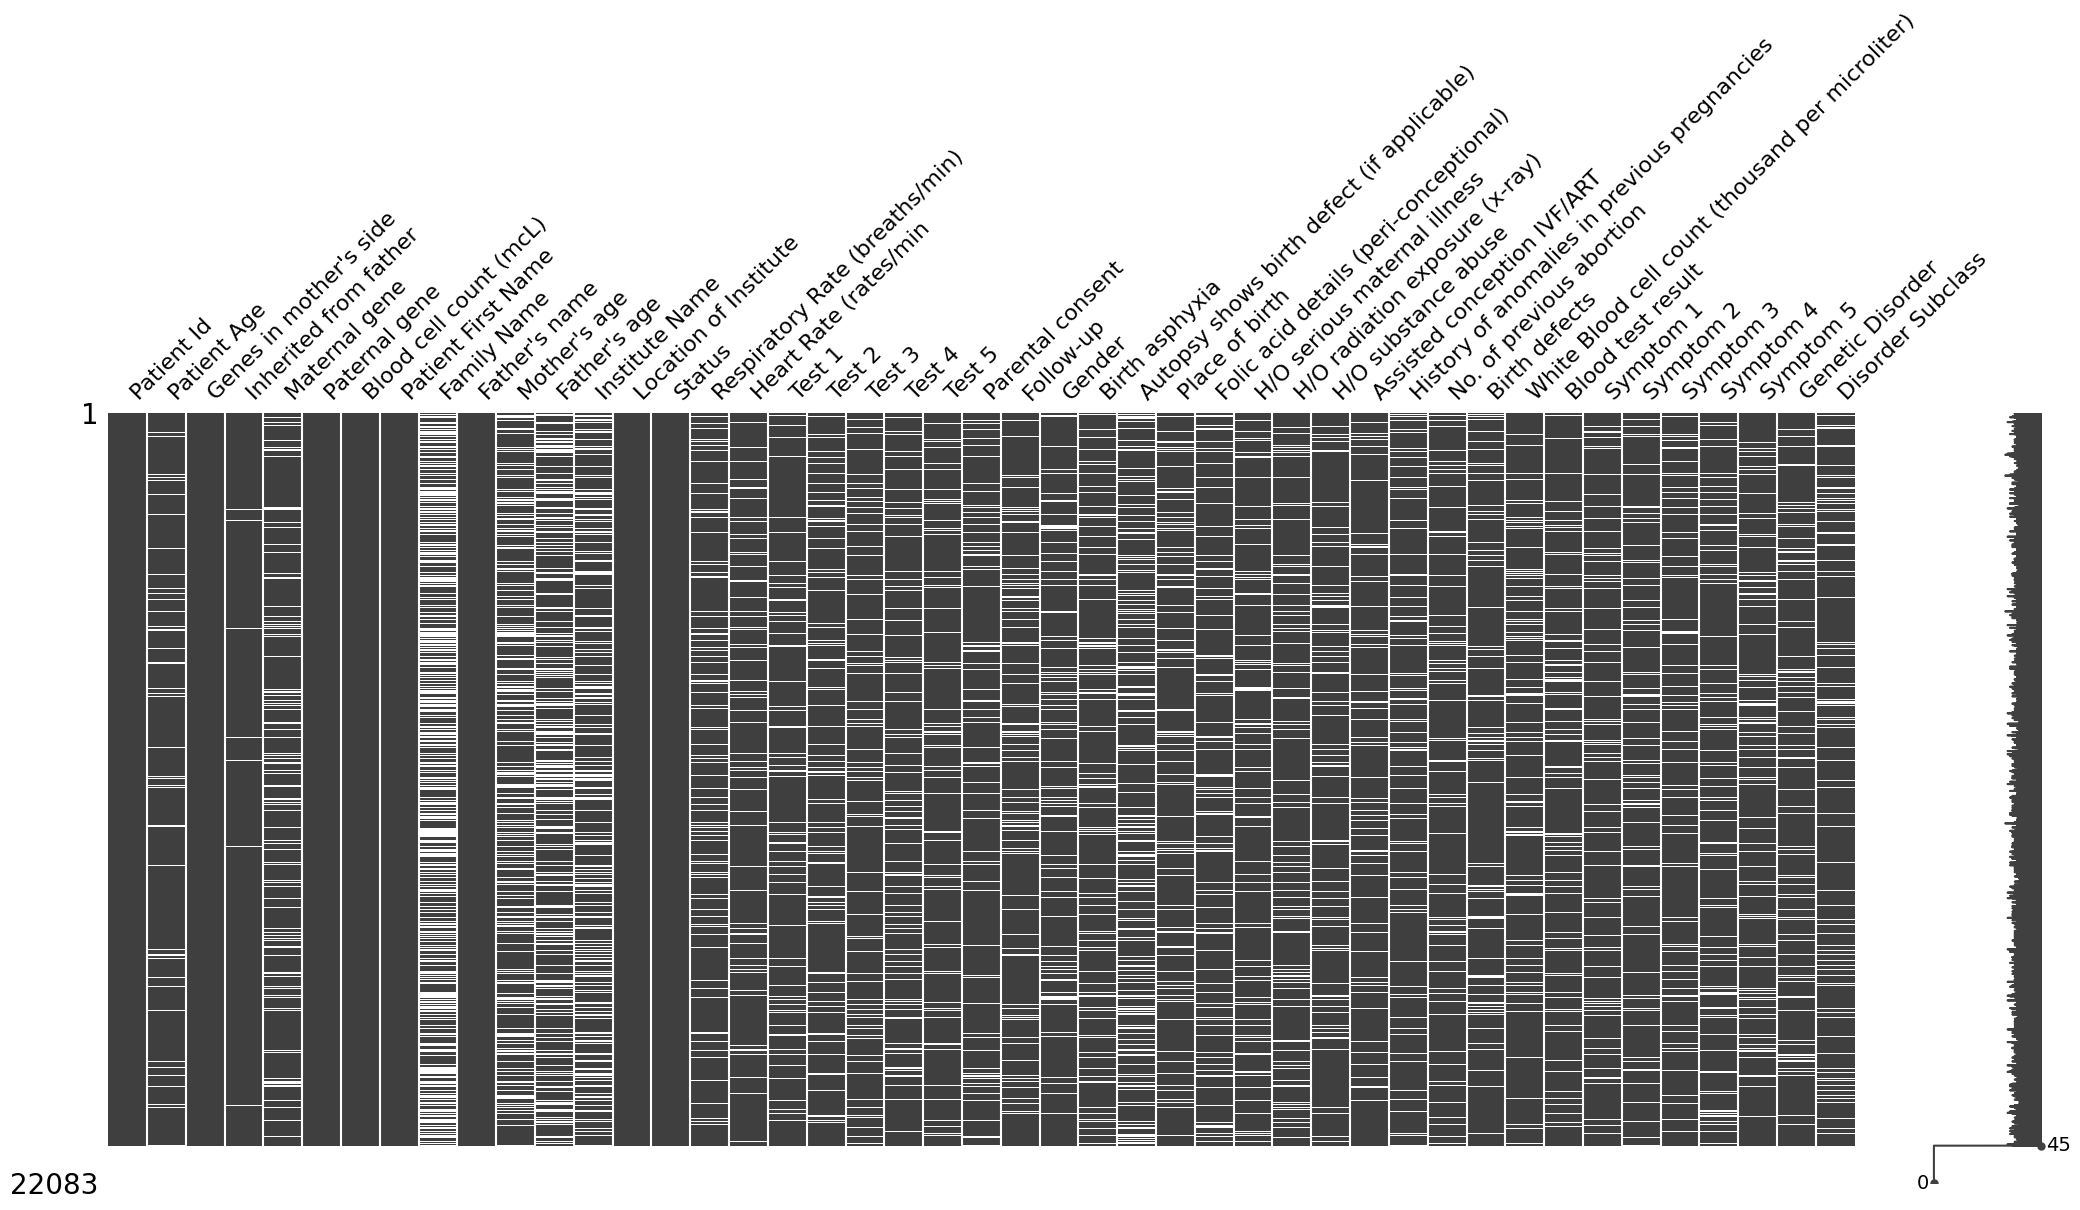

In [15]:
msno.matrix(df)
plt.show()

In [4]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(150, 150))
sns.heatmap( df.select_dtypes(include=['int64', 'float64']).corr(),annot=True,fmt = ".2f",cmap='viridis')
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [16]:
def fill_missing(X_train, X_test):

    X_train_filled = X_train.copy()
    X_test_filled = X_test.copy()
    
    for column in X_train.columns:
        if X_train[column].isnull().any():
            if X_train[column].dtype == 'object':
                mode_value = X_train[column].mode()[0] 
                X_train_filled[column] = X_train[column].fillna(mode_value)
                X_test_filled[column] = X_test[column].fillna(mode_value)
            else:
                median_value = X_train[column].median()
                X_train_filled[column] = X_train[column].fillna(median_value)
                X_test_filled[column] = X_test[column].fillna(median_value)
    
    return X_train_filled, X_test_filled

In [17]:
def preprocess_data(df):
    df = df.drop(columns=[
        "Patient Id",
        "Family Name",
        "Institute Name",
        "Patient First Name",
        "Father's name",
        "Location of Institute",
        "Parental consent",
        "Test 1",
        "Test 2",
        "Test 3",
        "Test 4",
        "Test 5"
    ], errors='ignore')
    
    df = df.dropna(how='all')
    df = df.dropna(subset=["Genetic Disorder", "Disorder Subclass"])


    cat_columns = ['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']
   
    for col in cat_columns:
        df[col] = df[col].astype('object')

    
    disorder_mapping = {
        "Leber's hereditary optic neuropathy": "Mitochondrial genetic inheritance disorders",
        "Leigh syndrome": "Mitochondrial genetic inheritance disorders",
        "Mitochondrial myopathy": "Mitochondrial genetic inheritance disorders",
        "Alzheimer's": "Multifactorial genetic inheritance disorders",
        "Cancer": "Multifactorial genetic inheritance disorders",
        "Diabetes": "Multifactorial genetic inheritance disorders",
        "Cystic fibrosis": "Single-gene inheritance diseases",
        "Hemochromatosis": "Single-gene inheritance diseases",
        "Tay-Sachs": "Single-gene inheritance diseases",
    }

  
    def fill_genetic_disorder(row):
        if pd.isnull(row["Genetic Disorder"]) and row["Disorder Subclass"] in disorder_mapping:
            return disorder_mapping[row["Disorder Subclass"]]
        else:
            return row["Genetic Disorder"]

    df["Genetic Disorder"] = df.apply(fill_genetic_disorder, axis=1)

    # Fill missing values in 'Genetic Disorder' and 'Disorder Subclass'
    def fill_missing_values(df):

        for subclass in df['Disorder Subclass'].dropna().unique():
            mode_genetic_disorder = df[df['Disorder Subclass'] == subclass]['Genetic Disorder'].mode()
            if not mode_genetic_disorder.empty:
                df.loc[
                    (df['Disorder Subclass'] == subclass) & (df['Genetic Disorder'].isnull()),
                    'Genetic Disorder'
                ] = mode_genetic_disorder[0]

        # Fill missing 'Disorder Subclass' based on 'Genetic Disorder'
        for disorder in df['Genetic Disorder'].dropna().unique():
            mode_disorder_subclass = df[df['Genetic Disorder'] == disorder]['Disorder Subclass'].mode()
            if not mode_disorder_subclass.empty:
                df.loc[
                    (df['Genetic Disorder'] == disorder) & (df['Disorder Subclass'].isnull()),
                    'Disorder Subclass'
                ] = mode_disorder_subclass[0]

        return df

    df = fill_missing_values(df)
    

    # Fill null values in each group
    grouped = df.groupby(["Genetic Disorder", "Disorder Subclass"])

    # def fill_nulls(group):
    #     for column in group.columns:
    #         if group[column].isnull().any():
    #             if group[column].dtype == 'object':
    #                 mode_value = group[column].mode()
    #                 if not mode_value.empty:
    #                     group[column] = group[column].fillna(mode_value[0])
    #             else:
    #                 median_value = group[column].median()
    #                 group[column] = group[column].fillna(median_value)
    #     return group

    # df_filled = grouped.apply(fill_nulls).reset_index(drop=True)

    # Define values to replace with 'Missing'
    missing_values = ["No record", "Not available", "Not applicable", "-", "Ambiguous"]
    df_filled = df
    # Replace specified values with 'Missing' in categorical columns
    categorical_cols = df_filled.select_dtypes(include='object').columns
    for col in categorical_cols:
        df_filled[col] = df_filled[col].replace(missing_values, 'Missing')
        
    df_filled["Mother Age at Birth"] = df_filled["Mother's age"] - df_filled["Patient Age"]
    df_filled["Father Age at Birth"] = df_filled["Father's age"] - df_filled["Patient Age"]
    
    df_filled['Symptom Count'] = df_filled[['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']].sum(axis=1)
    # df_filled.drop(columns=['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5'], inplace=True)
    df_filled['Total Blood Cell Count'] = df_filled['Blood cell count (mcL)'] + df_filled['White Blood cell count (thousand per microliter)']
    df_filled.drop(columns=['Blood cell count (mcL)', 'White Blood cell count (thousand per microliter)'], inplace=True)
    return df_filled

In [18]:
df_pr = preprocess_data(df)

/tmp/ipykernel_31/3784092111.py:96: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filled[col] = df_filled[col].replace(missing_values, 'Missing')


In [19]:
numerical_cols = df_pr.select_dtypes(include=["number"]).columns
categorical_cols = df_pr.select_dtypes(include=["object"]).columns

In [20]:
# label_encoder = LabelEncoder()

# for col in categorical_cols:
#     df_pr[col] = label_encoder.fit_transform(df_pr[col])

In [21]:
X = df_pr.drop(columns=['Genetic Disorder','Disorder Subclass'])
Y = df_pr[['Genetic Disorder']]

x_train, x_test, y_train, y_test = train_test_split (X, Y, test_size=0.2, 
                                                     random_state=42, stratify=Y)

In [22]:
x_train, x_test = fill_missing(x_train, x_test)

In [24]:
!pip install -U lightautoml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.0/399.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 110.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.9 MB/s eta 0:00:0

In [25]:
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from lightautoml.automl.base import AutoML
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBAdvancedPipeline
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.features.linear_pipeline import LinearFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.selection.importance_based import ImportanceCutoffSelector
from lightautoml.pipelines.selection.importance_based import (
    ModelBasedImportanceEstimator,
)
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.utils.timer import PipelineTimer

In [27]:
np.random.seed(42)
data = df_pr.copy()
data.drop(columns=['Disorder Subclass'], inplace=True)



from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Genetic Disorder'] = le.fit_transform(data['Genetic Disorder'])
data.rename(columns={'Genetic Disorder': 'TARGET'}, inplace=True)
train, test = train_test_split(data, test_size=2000, random_state=42, stratify=data['TARGET'])
# ======================================================================================
print("Create timer...")
timer = PipelineTimer(600, mode=2)
print("Timer created...")
# ======================================================================================
print("Create selector...")
timer_gbm = timer.get_task_timer("gbm")
feat_sel_0 = LGBSimpleFeatures()
mod_sel_0 = BoostCB(timer=timer_gbm)
imp_sel_0 = ModelBasedImportanceEstimator()
selector_0 = ImportanceCutoffSelector(
    feat_sel_0,
    mod_sel_0,
    imp_sel_0,
    cutoff=0,
)
print("Selector created...")
# ======================================================================================
print("Create gbms...")
feats_gbm_0 = LGBAdvancedPipeline(top_intersections=4, feats_imp=imp_sel_0)
timer_gbm_0 = timer.get_task_timer("gbm")
timer_gbm_1 = timer.get_task_timer("gbm")

gbm_0 = BoostCB(timer=timer_gbm_0, default_params={"devices": "0"})
gbm_1 = BoostCB(timer=timer_gbm_1, default_params={"devices": "0"})

tuner_0 = OptunaTuner(n_trials=10, timeout=10, fit_on_holdout=True)
gbm_lvl0 = MLPipeline(
    [(gbm_0, tuner_0), gbm_1],
    pre_selection=selector_0,
    features_pipeline=feats_gbm_0,
    post_selection=None,
)
print("Gbms created...")
# ======================================================================================
print("Create linear...")
feats_reg_0 = LinearFeatures(output_categories=True, sparse_ohe="auto")

timer_reg = timer.get_task_timer("reg")
reg_0 = LinearLBFGS(timer=timer_reg)

reg_lvl0 = MLPipeline([reg_0], pre_selection=None, features_pipeline=feats_reg_0, post_selection=None)
print("Linear created...")
# ======================================================================================
print("Create reader...")
reader = PandasToPandasReader(
    Task(
        "multiclass",
        metric="crossentropy",
    ),
    samples=None,
    max_nan_rate=1,
    max_constant_rate=1,
    advanced_roles=True,
    drop_score_co=-1,
    n_jobs=1,
)
print("Reader created...")
# ======================================================================================
print("Create blender...")
blender = WeightedBlender()
print("Blender created...")
# ======================================================================================
print("Create AutoML...")
automl = AutoML(
    reader=reader,
    levels=[[gbm_lvl0, reg_lvl0]],
    timer=timer,
    blender=blender,
    skip_conn=False,
)
print("AutoML created...")
# ======================================================================================
print("Fit predict...")
oof_pred = automl.fit_predict(train, roles={"target": "TARGET"})
print("Finished fitting...")

test_pred = automl.predict(test)
print("Prediction for test data:\n{}\nShape = {}".format(test_pred, test_pred.shape))
# ======================================================================================
print("Check scores...")
# use only not nan
not_nan = np.any(~np.isnan(oof_pred.data), axis=1)

print("OOF score: {}".format(log_loss(train["TARGET"].values[not_nan], oof_pred.data[not_nan])))
print("TEST score: {}".format(log_loss(test["TARGET"].values, test_pred.data)))
# ======================================================================================
for dat, df, name in zip([oof_pred, test_pred], [train, test], ["train", "test"]):
    print("Check aucs {0}...".format(name))
    for c in range(3):
        _sc = roc_auc_score((df["TARGET"].values == c).astype(np.float32), dat.data[:, c])
        print("Cl {0} auc score: {1}".format(c, _sc))

Create timer...
Timer created...
Create selector...
Selector created...
Create gbms...
Gbms created...
Create linear...
Linear created...
Create reader...
Reader created...
Create blender...
Blender created...
Create AutoML...
AutoML created...
Fit predict...
Finished fitting...
Prediction for test data:
array([[0.27242795, 0.27863437, 0.44893762],
       [0.2547013 , 0.3655465 , 0.37975222],
       [0.70412785, 0.01023979, 0.28563237],
       ...,
       [0.6683938 , 0.02825797, 0.3033482 ],
       [0.6455067 , 0.06669927, 0.28779405],
       [0.31635937, 0.02026675, 0.6633739 ]], dtype=float32)
Shape = (2000, 3)
Check scores...
OOF score: 0.8046328679787481
TEST score: 0.7939538959656998
Check aucs train...
Cl 0 auc score: 0.7223503619324312
Cl 1 auc score: 0.8726904917868036
Cl 2 auc score: 0.6562532721790261
Check aucs test...
Cl 0 auc score: 0.72968316665266
Cl 1 auc score: 0.8882548550146315
Cl 2 auc score: 0.64795344629329


In [28]:
from sklearn.metrics import classification_report

# Предсказанные классы
y_true = test["TARGET"].values
y_pred = np.argmax(test_pred.data, axis=1)

# Классы (если нужен текстовый отчёт с названиями, а не индексами)
class_names = le.classes_

# Выводим отчёт
print(classification_report(y_true, y_pred, target_names=class_names))


                                              precision    recall  f1-score   support

 Mitochondrial genetic inheritance disorders       0.63      0.81      0.71      1022
Multifactorial genetic inheritance disorders       0.47      0.31      0.38       210
            Single-gene inheritance diseases       0.55      0.40      0.47       768

                                    accuracy                           0.60      2000
                                   macro avg       0.55      0.51      0.52      2000
                                weighted avg       0.59      0.60      0.58      2000



In [35]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

task = Task('multiclass', metric='crossentropy')

automl = TabularAutoML(task=task, timeout=600)

oof = automl.fit_predict(train, roles={'target': 'TARGET'})
preds = automl.predict(test)

In [37]:
from sklearn.metrics import classification_report
y_pred = preds.data.argmax(axis=1)
print(classification_report(test["TARGET"], y_pred))

              precision    recall  f1-score   support

           0       0.65      0.80      0.72      1022
           1       0.49      0.31      0.38       210
           2       0.56      0.44      0.49       768

    accuracy                           0.61      2000
   macro avg       0.57      0.52      0.53      2000
weighted avg       0.60      0.61      0.60      2000



In [7]:
!git clone https://github.com/yandex-research/tabm

Cloning into 'tabm'...
remote: Enumerating objects: 74591, done.
remote: Counting objects: 100% (7046/7046), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 74591 (delta 7026), reused 6977 (delta 6976), pack-reused 67545 (from 2)
Receiving objects: 100% (74591/74591), 17.37 MiB | 23.82 MiB/s, done.
Resolving deltas: 100% (45911/45911), done.
Updating files: 100% (60179/60179), done.


In [9]:
!cd tabm

In [14]:
import sys
sys.path.append('/kaggle/working/tabm')  # или полный путь, если папка не рядом

from tabm_reference import Model, make_parameter_groups, make_model

ImportError: cannot import name 'make_model' from 'tabm_reference' (/kaggle/working/./tabm/tabm_reference.py)

In [ ]:
!pip install rtdl_num_embeddings

In [5]:
!git clone https://github.com/yandex-research/rtdl-num-embeddings

Cloning into 'rtdl-num-embeddings'...
remote: Enumerating objects: 33575, done.
remote: Counting objects: 100% (801/801), done.
remote: Compressing objects: 100% (371/371), done.
remote: Total 33575 (delta 448), reused 774 (delta 427), pack-reused 32774 (from 1)
Receiving objects: 100% (33575/33575), 12.25 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (20438/20438), done.
Updating files: 100% (29342/29342), done.


In [11]:
import math
import random
import warnings
from typing import Literal, NamedTuple

import numpy as np
import rtdl_num_embeddings  # https://github.com/yandex-research/rtdl-num-embeddings
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn.functional as F
import torch.optim
from torch import Tensor
from tqdm.std import tqdm

warnings.simplefilter('ignore')
from tabm_reference import Model, make_parameter_groups

warnings.resetwarnings()

In [12]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from tabm_reference import Model, make_parameter_groups
import rtdl_num_embeddings
from tqdm import tqdm
from tabm_reference import make_model
# Установка сидов
seed = 42
random.seed(seed)
np.random.seed(seed + 1)
torch.manual_seed(seed + 2)

# === 1. Загрузка датасета ===

# Предположим, что столбец target — это целевая переменная
# Если целевая переменная называется иначе — замените
assert 'TARGET' in data.columns

# === 2. Предобработка ===
features = data.drop(columns=['TARGET'])
target = data['TARGET']

# Кодируем категориальные признаки, если есть
features = pd.get_dummies(features)

# Масштабируем непрерывные признаки
scaler = StandardScaler()
X = scaler.fit_transform(features).astype(np.float32)

# Кодируем целевые метки
le = LabelEncoder()
y = le.fit_transform(target).astype(np.int64)

n_classes = len(np.unique(y))
task_type = 'multiclass'

# === 3. Train/Val split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

# === 4. Модель TabM ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = make_model(
    n_num_features=X.shape[1],  # количество числовых признаков
    cat_cardinalities=None,     # или список, если есть категориальные
    d_out=n_classes             # число классов
).to(device)

optimizer = torch.optim.AdamW(
    make_parameter_groups(model),
    lr=1e-3,
)

# === 5. Обучение ===
def compute_loss(logits, y):
    return F.cross_entropy(logits, y)

n_epochs = 10
batch_size = 256

X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).to(device)
X_val_tensor = torch.tensor(X_val).to(device)
y_val_tensor = torch.tensor(y_val).to(device)

for epoch in range(n_epochs):
    model.train()
    idx = torch.randperm(len(X_train_tensor))
    for i in range(0, len(X_train_tensor), batch_size):
        batch_idx = idx[i:i+batch_size]
        X_batch, y_batch = X_train_tensor[batch_idx], y_train_tensor[batch_idx]
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = compute_loss(logits, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        logits_val = model(X_val_tensor)
        preds = logits_val.argmax(1).cpu().numpy()
        acc = accuracy_score(y_val, preds)
        f1 = f1_score(y_val, preds, average='macro')
        print(f"Epoch {epoch+1}: Val Accuracy = {acc:.4f}, Macro F1 = {f1:.4f}")

ImportError: cannot import name 'make_model' from 'tabm_reference' (/kaggle/working/./tabm/tabm_reference.py)